In [1]:
# 7个字段说明：
# 1.订单编号：订单编号
# 2.总金额：订单总金额
# 3.买家实际支付金额：总金额 - 退款金额（在已付款的情况下）。金额为0（在未付款的情况下）
# 4.收货地址：各个省份
# 5.订单创建时间：下单时间
# 6.订单付款时间：付款时间
# 7.退款金额：付款后申请退款的金额。如无付过款，退款金额为0

# 分析目的：
# 1.订单每个环节的转化转化率
# 2.订单成交的时间（按天）趋势(按实际成交）
# 3.订单数在地图上的分布

In [165]:
# 模塊導入
import numpy as np
import pandas as pd
import os
import warnings
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#警告过滤器,忽略匹配的警告
warnings.filterwarnings('ignore')

In [95]:
#讀取數據
#engine：使用的解释器。{‘c’, ‘python’}二选一
df=pd.read_csv('tmall_order_report.csv',engine='python',encoding='utf')

In [96]:
#顯示前5筆資料
df.head()

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,1,178.8,0.0,上海,2020-02-21 00:00:00,NaN,0.0
1,2,21.0,21.0,内蒙古自治区,2020-02-20 23:59:54,2020-02-21 00:00:02,0.0
2,3,37.0,0.0,安徽省,2020-02-20 23:59:35,NaN,0.0
3,4,157.0,157.0,湖南省,2020-02-20 23:58:34,2020-02-20 23:58:44,0.0
4,5,64.8,0.0,江苏省,2020-02-20 23:57:04,2020-02-20 23:57:11,64.8


In [97]:
#顯示最後5筆資料
df.tail()

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
28005,28006,37.0,37.0,四川省,2020-02-27 00:01:00,2020-02-27 00:01:10,0.0
28006,28007,69.0,0.0,上海,2020-02-27 00:00:18,NaN,0.0
28007,28008,69.0,0.0,上海,2020-02-27 00:00:17,NaN,0.0
28008,28009,37.0,37.0,辽宁省,2020-02-27 00:00:09,2020-02-27 00:00:17,0.0
28009,28010,37.0,37.0,广东省,2020-02-27 00:00:06,2020-02-27 00:00:11,0.0


In [98]:
#處理數據
#規範字段名稱
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址 ', '订单创建时间', '订单付款时间 ', '退款金额'], dtype='object')

In [99]:
#將字段中空格去掉,規範字段名稱
df=df.rename(columns={'收货地址 ':'收货地址','订单付款时间 ':'订单付款时间'})
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28010 entries, 0 to 28009
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   订单编号      28010 non-null  int64  
 1   总金额       28010 non-null  float64
 2   买家实际支付金额  28010 non-null  float64
 3   收货地址      28010 non-null  object 
 4   订单创建时间    28010 non-null  object 
 5   订单付款时间    24087 non-null  object 
 6   退款金额      28010 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ MB


In [101]:
#重复值
#判断有多少重复的记录
df.duplicated().sum()

0

In [102]:
#缺失值
df.isnull().sum()
# 订单付款时间 有2923个缺失值，属于正常现象，说明这些单位付过款，无需处理

订单编号           0
总金额            0
买家实际支付金额       0
收货地址           0
订单创建时间         0
订单付款时间      3923
退款金额           0
dtype: int64

In [103]:
# 订单转化率-漏斗图

# 计算每个环节的数据
# 将等到如下的数据：
# [['总订单数', '28010'],
# ['付款订单数', '24087'],
# ['到款订单数', '18955'],
# ['全额到款订单数', '18441']]

# 1.买家实际支付金额：总金额 - 退款金额（在已付款的情况下）。金额为0（在未付款的情况下）
# 2.退款金额：付款后申请退款的金额。如无付过款，退款金额为0

In [104]:
#订单总笔数
dict_convs=dict()
dict_convs['总订单数']=len(df)

In [105]:
#付过款的订单数
df_payed=df[df['订单付款时间'].notnull()]  #付款时间不为空的，表示付过款
dict_convs['付款订单数']=len(df_payed)
len(df_payed)

24087

In [106]:
#到款订单数
# 买家实际支付金额：总金额 - 退款金额（在已付款的情况下）
df_trans=df_payed[df_payed['买家实际支付金额'] != 0]  # 买家实际支付金额不为0的，说明订单商家收到过款
dict_convs["到款订单数"]=len(df_trans)

In [107]:
# 全额到款订单数
df_trans_full=df_payed[df_payed['退款金额'] == 0] ## 在付款的订单中，退款金额为0的，说明没有退款，表示全额收款
dict_convs['全额到款订单数']=len(df_trans_full)

In [108]:
# 查看转化数据
dict_convs

{'总订单数': 28010, '付款订单数': 24087, '到款订单数': 18955, '全额到款订单数': 18441}

In [109]:
#转化率-呈现
#to_frame()方法，但是当Series的index也需要转变为DataFrame
df_convs=pd.Series(dict_convs,name='订单数').to_frame()
df_convs

,订单数
总订单数,28010
付款订单数,24087
到款订单数,18955
全额到款订单数,18441


In [110]:
# 添加总体转化率,每个环节除以总订单数
#.loc先行後列，中間用逗號（,）分割，取总订单数(行)的订单数(列) 對應的資料=28010
total_convs=df_convs['订单数']/df_convs.loc['总订单数',"订单数"]*100
df_convs['总体转化率']=total_convs.apply(lambda x : round(x,0))
df_convs

,订单数,总体转化率
总订单数,28010,100.0
付款订单数,24087,86.0
到款订单数,18955,68.0
全额到款订单数,18441,66.0


In [111]:
from pyecharts.charts import Funnel #漏斗图
from pyecharts import options as opts #

In [112]:
#漏斗图制作
funnel=Funnel().add(
                    series_name='总体转化率',
                    data_pair=[list(z) for z in zip(df_convs.index,df_convs['总体转化率'])],
                    is_selected=True,
                    label_opts=opts.LabelOpts(position='inside')
                    )
funnel.set_series_opts(tooltip_opts=opts.TooltipOpts(formatter='{a}<br/>{b}:{c}%'))
funnel.set_global_opts(title_opts=opts.TitleOpts(title='总体转化率'),
#                         tooltip_opts = opts.TooltipOpts(formatter = '{a}<br\>{b}:{c}%'),                      
                      )
funnel.render_notebook()

D:\Users\user\anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [113]:
#单一环节转化率
#通过shift函数里面的值来控制向前还是向后偏移, 缺少的值会填充NaN.
single_convs=df_convs['订单数'].shift()
df_convs['单一环节转化率']=single_convs.fillna(df_convs.loc['总订单数','订单数'])
df_convs['单一环节转化率']=round((df_convs['订单数']/df_convs['单一环节转化率']*100),0)
df_convs

,订单数,总体转化率,单一环节转化率
总订单数,28010,100.0,100.0
付款订单数,24087,86.0,86.0
到款订单数,18955,68.0,79.0
全额到款订单数,18441,66.0,97.0


In [114]:
#单一环节转化率 漏斗图
funnel=Funnel().add(
                    series_name='单一环节转化率',
                    data_pair=[list(z) for z in zip(df_convs.index,df_convs['单一环节转化率'])],
                    is_selected=True,
                    label_opts=opts.LabelOpts(position='inside')
                    )
funnel.set_series_opts(tooltip_opts=opts.TooltipOpts(formatter='{a}<br/>{b}:{c}%'))
funnel.set_global_opts(title_opts=opts.TitleOpts(title='单一环节转化率')
#                         tooltip_opts = opts.TooltipOpts(formatter = '{a}<br\>{b}:{c}%'),
                      )
                        
funnel.render_notebook()

D:\Users\user\anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [115]:
#整体订单数趋势
#按到款订单统计
# df_trans['订单创建时间']=df_trans['订单创建时间'].astype('datetime64')
# df_trans=df_trans.set_index('订单创建时间')
df_trans.head()

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
1,2,21.0,21.0,内蒙古自治区,2020-02-20 23:59:54,2020-02-21 00:00:02,0.0
3,4,157.0,157.0,湖南省,2020-02-20 23:58:34,2020-02-20 23:58:44,0.0
5,6,327.7,148.9,浙江省,2020-02-20 23:56:39,2020-02-20 23:56:53,178.8
6,7,357.0,357.0,天津,2020-02-20 23:56:36,2020-02-20 23:56:40,0.0
7,8,53.0,53.0,浙江省,2020-02-20 23:56:12,2020-02-20 23:56:16,0.0


'订单编号'

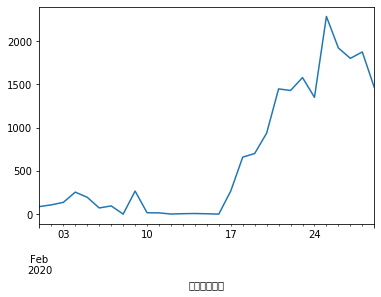

In [130]:
#resample()這個函數主要是用來對時間序列做頻率轉換
# se_trans_month=df_trans.resample('D')['订单编号'].count()
se_trans_month.plot()
se_trans_month.name

In [119]:
from pyecharts.charts import Line

In [120]:
(
    Line().add_xaxis(xaxis_data=list(se_trans_month.index.day.map(str)))
       .add_yaxis(series_name='订单数',
                  y_axis=se_trans_month,)

.set_global_opts(yaxis_opts=opts.AxisOpts(
                 splitline_opts=opts.SplitLineOpts(is_show=True)   
                                          )
                 ).render_notebook()
)

#2月上半个月，企业多数未复工，快递停运，无法发货
# 下半个月，随着企业复工逐渐增多，订单数开始上涨

D:\Users\user\anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)


In [121]:
#订单平均价格
df_trans['买家实际支付金额'].mean()

100.36861777895066

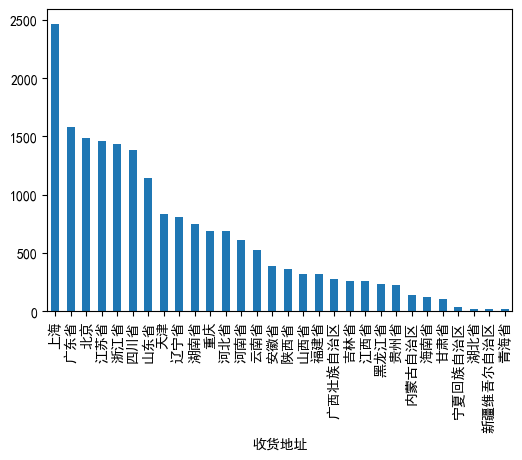

In [166]:
#销量区域分布-地理图
se_trans_map=df_trans.groupby('收货地址')['收货地址'].count().sort_values(ascending=False)
plt.figure(dpi=100)
se_trans_map.plot(kind='bar')

In [127]:
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

In [136]:
# 为了保持由于下面的地理分布图使用的省份名称一致，定义一个处理自治区的函数
def strip_region(iterable):
    result=[]
    for i in iterable:
        if i.endswith('自治区'):
            if i == '内蒙古自治区':
                i=i[:3]
                result.append(i)
            else:
                result.append(i[:2])
        else:
            result.append(i)
    return result

In [138]:
# 处理自治区
se_trans_map.index=strip_region(se_trans_map.index)

# 去掉末位‘省’字
se_trans_map.index=se_trans_map.index.str.strip('省')

In [139]:
import pyecharts.options as opts
from pyecharts.charts import Map

In [140]:
#地理分布图
(
Map().add(series_name='订单数',data_pair=[list(i) for i in se_trans_map.items()])
     .set_global_opts(visualmap_opts=opts.VisualMapOpts(max_=max(se_trans_map)*0.6))
     .render_notebook()
)

D:\Users\user\anaconda3\lib\site-packages\pyecharts\charts\chart.py:14: PendingDeprecationWarning: pyecharts 所有图表类型将在 v1.9.0 版本开始强制使用 ChartItem 进行数据项配置 :)
  super().__init__(init_opts=init_opts)
